# Kaggle TGS Geoseismic competition

In [ ]:
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/DeepLabv3Plus.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/ImageReader.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/ModelUNet.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/models.py
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/requirements.txt
!wget -q https://raw.githubusercontent.com/douglas125/McLyEdSegmentation/master/LinkNet.py

In [1]:
!pip install -r requirements.txt

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8188585273154669277
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280308634
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11032256937816566186
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 27a3:00:00.0, compute capability: 3.7"
]


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [4]:
#!kaggle datasets list

In [5]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 15.6MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 47.1MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 922k/922k [00:00<00:00, 70.0MB/s]
 95%|██████████████████████████████████████▉  | 155M/163M [00:01<00:00, 131MB/s]
100%|█████████████████████████████████████████| 163M/163M [00:01<00:00, 122MB/s]
 76%|█████████████████████████████         | 29.0M/37.9M [00:00<00:00, 70.4MB/s]
100%|███████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 104MB/s]


Reference: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

# Data Exploration

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [8]:
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

C:\Users\Douglas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [3]:
!ls tgs-salt-identification-challenge/testData/

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [4]:
depthFile = pd.read_csv('depths.csv' )
depthFile.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [5]:
depthFile[depthFile['id'] == '4ac19fb269'].z.tolist()[0]

306

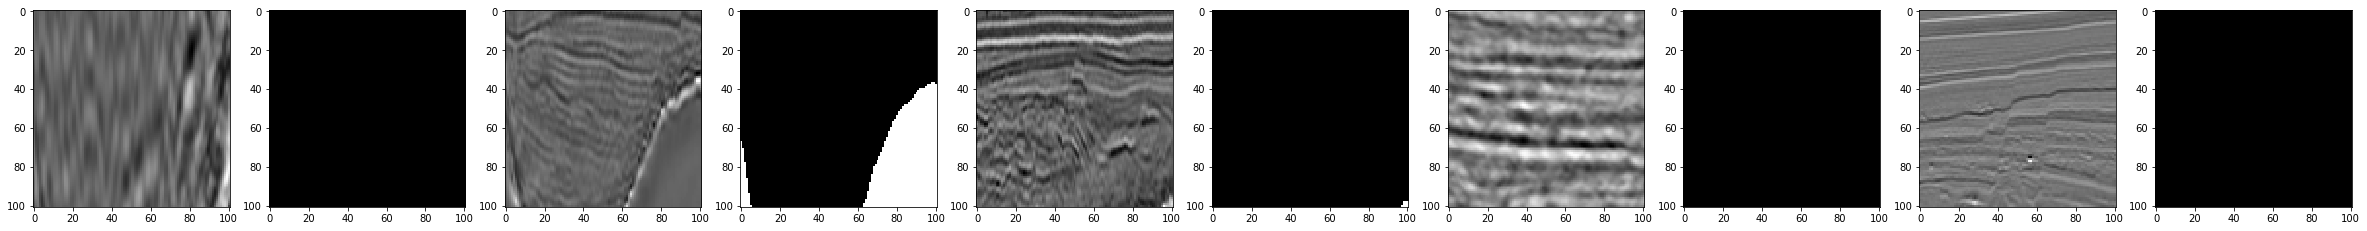

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,25))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(trainFolder + 'images/' + img_name + '.png')
    img_mask = load_img(trainFolder + 'masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [8]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [10]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print('Mean: {} Std: {}'.format(X_train_mean, X_train_std))
X_train = X_train/255.0#(X_train-X_train_mean)/(2*X_train_std)

#X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
#X_test = (X_test-X_train_mean)/(2*X_train_std)

Getting images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 4444/4444 [00:16<00:00, 269.38it/s]


Ignored 0 files
Mean: 120.07334081364219 Std: 41.49536224150379


In [10]:
#import pickle
#with open('test_ids.pkl', 'rb') as f:
#    test_ids_linux = pickle.load(f)

#test_ids_linux[0:10]    

['95e0620119.png',
 '63c62f219c.png',
 'a1db1ba4e9.png',
 '99fddf686c.png',
 'cc924f5758.png',
 'f90d686e01.png',
 '14d1b7816a.png',
 'e146c20d21.png',
 'af29e02e15.png',
 '75fb042981.png']

In [11]:
#read test data along with some predictions
X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)#, presetImgIds = test_ids_linux)
X_test = X_test/255.0 #(X_test-X_train_mean)/(2*X_train_std)
#test_ids = test_ids_linux

Getting images and masks ... 


100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:54<00:00, 329.13it/s]


Ignored 0 files


In [12]:
y_test_pred = np.load('pred.npy')
y_test_pred.shape

(18000, 101, 101, 1)

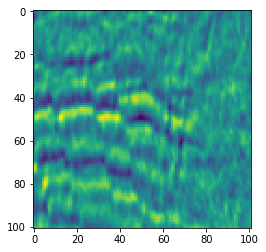

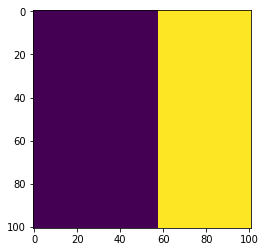

In [452]:
# Check if training data looks all right
ix = np.random.randint(0, len(X_train))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_train[ix,:,:,0])
plt.show()
plt.imshow(Y_train[ix,:,:,0])
plt.show()

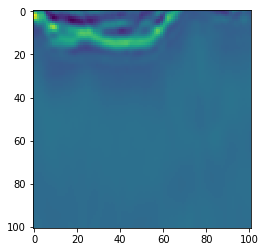

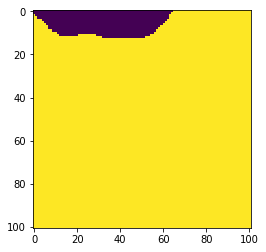

In [497]:
# Check if test data looks all right
ix = np.random.randint(0, len(X_test))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_test[ix,:,:,0])
plt.show()
plt.imshow(y_test_pred[ix,:,:,0]>0.5)
plt.show()

# Keras datagen

In [11]:
#shuffle data
for k in tqdm(range( len(X_train) )):
    getId0 = np.random.randint(len(X_train))
    getId1 = np.random.randint(len(X_train))
    
    temp = X_train[getId0]
    X_train[getId0] = X_train[getId1]
    X_train[getId1] = temp

    temp = Y_train[getId0]
    Y_train[getId0] = Y_train[getId1]
    Y_train[getId1] = temp

    temp = depthVals[getId0]
    depthVals[getId0] = depthVals[getId1]
    depthVals[getId1] = temp


100%|███████████████████████████████████████████████████████████████████████████| 3908/3908 [00:00<00:00, 28124.96it/s]


In [61]:
valRatio = 0.035


nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}'.format(X_train0.shape, X_val.shape))

(3322, 101, 101, 1), (586, 101, 101, 1)


In [62]:
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rescale, resize, downscale_local_mean


# we create two instances with the same arguments
data_gen_argsMask = dict(
                     rotation_range=3.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.013, #0
                     width_shift_range=0.11, # 0.03,
                     height_shift_range=0.2, #0.3,
                     horizontal_flip=True,
                     cval=0,
                     fill_mode = "reflect"  #reflect
                     #vertical_flip=True #see if helps
                    )

data_gen_args = {}
for key in data_gen_argsMask:
    data_gen_args[key] = data_gen_argsMask[key]
    
#data_gen_args['featurewise_center'] = True
#data_gen_args['featurewise_std_normalization'] = True
#data_gen_args['zca_whitening'] = True #this or normalization

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_argsMask)
depth_datagen = ImageDataGenerator()


seed=7
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
#mask_datagen.fit(Y_train0, augment=True, seed=seed)
#depth_datagen.fit(d_train0, augment=False, seed=seed)

image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32

#maximum random crop image size
randomCropMaxSize=120
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=7, batch_size=bSize)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        
        #random crops
        for kk in range(len(X1i)):
            rSize = np.random.randint(101, randomCropMaxSize)
            new_shape = [rSize, rSize]
            cropPosition = [np.random.randint(rSize-100), np.random.randint(rSize-100)]
            X1i[kk] = ResizeAndCrop(X1i[kk], new_shape, cropPosition)
            X3i[kk] = ResizeAndCrop(X3i[kk], new_shape, cropPosition)>0.5
        
        yield [X1i, X2i], X3i

def multi_input_genAE(X1, X2):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        
        #random crops
        for kk in range(len(X1i)):
            rSize = np.random.randint(101, randomCropMaxSize)
            new_shape = [rSize, rSize]
            cropPosition = [np.random.randint(rSize-100), np.random.randint(rSize-100)]
            X1i[kk] = ResizeAndCrop(X1i[kk], new_shape, cropPosition)
        
        yield [X1i, X2i], X1i        
        
def ResizeAndCrop(img, newShape, cropPos):
    img_resized = resize(img, newShape, mode='reflect')
    ans = img_resized[cropPos[0]:cropPos[0]+img.shape[0], cropPos[1]:cropPos[1]+img.shape[1]]
    return ans

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) 
all_generator = multi_input_genAE(X_train0+X_test, d_train0+d_test)

666.0


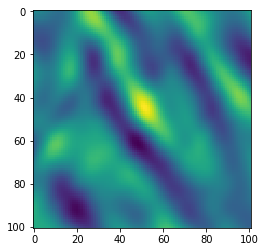

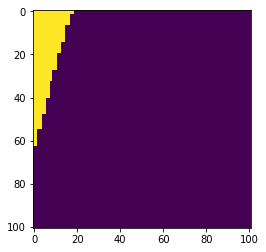

In [86]:
ans = next(train_generator)
print(ans[0][1][17,0,0,0])
plt.imshow( ans[0][0][17,:,:,0] )
plt.show()
plt.imshow( ans[1][17,:,:,0] )
plt.show()

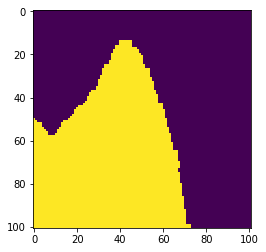

In [47]:
#resizedImg = ResizeAndCrop(ans[0][0][17,:,:], [120,120], [10,10])
resizedImg = ResizeAndCrop(ans[1][17,:,:], [120,120], [10,10])>0
resizedImg.shape
plt.imshow( resizedImg[:,:,0] )

# UNet model

In [1]:
import ModelUNet
import DeepLabv3Plus
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D, Add, Conv2D, Concatenate, SeparableConv2D, MaxPooling2D
from keras.layers.core import Lambda

C:\Users\Douglas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def BuildUNetEncoder(convFunction, nFilter = 8, net_depth = 4, input_img_shape = (128,128,1), encoderSquash = 0, nBorderRefinementConvs = 2 ):
    inputImg = Input(input_img_shape)
    inputDepth = Input( (1,1,1) )

    uLayers = []

    curLayer = inputImg
    curLayer = convFunction(curLayer, nFilter)
    for k in range(net_depth):
        curLayer = convFunction(curLayer, (2**(1+k))*nFilter)
        if encoderSquash > 0:
            squashedLayer = Conv2D(encoderSquash, (1,1), activation=None, padding='same') (curLayer)
            uLayers.append(squashedLayer)
        else:
            uLayers.append(curLayer)
            
        curLayer = MaxPooling2D((2, 2)) (curLayer)

    #take depth into account in the deepest layer
    dim1 = input_img_shape[0] // (2**(net_depth))
    dim2 = input_img_shape[1] // (2**(net_depth))

    depthIn = Lambda(lambda x: ModelUNet._expand(x, dim1, dim2) )(inputDepth)
    curLayer = Concatenate()([curLayer, depthIn])
    
    curLayer = convFunction(curLayer, (2**net_depth)*nFilter)
    uLayers.append(curLayer)
    
    model = Model(inputs=[inputImg, inputDepth], outputs=uLayers, name='UNet_enc_{}'.format(net_depth) )
    return model

In [3]:
#m=BuildUNetEncoder(ModelUNet.ApplyDC, nFilter = 8, net_depth = 3, input_img_shape = (128,128,1))
#m.summary()

In [4]:
from keras.layers import Conv2DTranspose, BatchNormalization
def UNetDecoder(uLayers, convFunction, nFilter = 8, net_depth = 4, input_img_shape = (128,128,1), encoderSquash = 0, nBorderRefinementConvs = 2):
    """
    Builds UNet decoder for image segmentation
    """
    curLayer = uLayers[-1]
    for k in range(net_depth):
        curLayer = Conv2DTranspose((2**(net_depth-k))*nFilter, (2, 2), strides=(2, 2), padding='same') (curLayer)
        curLayer = BatchNormalization() (curLayer)
        curLayer = Concatenate()([curLayer, uLayers[net_depth-k-1] ])
        curLayer = convFunction(curLayer, (2**(net_depth-k))*nFilter)

    for k in range(nBorderRefinementConvs):
        curLayer = convFunction(curLayer, nFilter)
    
    return curLayer


def UNetDecoderAE(uLayers, convFunction, nFilter = 8, net_depth = 4, input_img_shape = (128,128,1), encoderSquash = 0, nBorderRefinementConvs = 2):
    """
    Builds UNet decoder for autoencoder training
    """
    curLayer = uLayers[-1]
    for k in range(net_depth):
        curLayer = Conv2DTranspose((2**(net_depth-k))*nFilter, (2, 2), strides=(2, 2), padding='same') (curLayer)
        curLayer = BatchNormalization() (curLayer)
        #curLayer = Concatenate()([curLayer, uLayers[net_depth-k-1] ])
        curLayer = convFunction(curLayer, (2**(net_depth-k))*nFilter)

    for k in range(nBorderRefinementConvs):
        curLayer = convFunction(curLayer, nFilter)
    
    return curLayer    

In [5]:
unetEnc = BuildUNetEncoder(ModelUNet.ApplyDC, nFilter = 8, net_depth = 3, input_img_shape = (128,128,1))

In [8]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

s=inputImg
dd=inputDepth

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

su = unetEnc([s,dd])
su = UNetDecoderAE(su, ModelUNet.ApplyDC, nFilter = 8, net_depth = 3, input_img_shape = (128,128,1))

outputs = su
outputs = Conv2D(1, (1,1))(outputs)
outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

modelAE = Model(inputs=[inputImg, inputDepth], outputs=outputs)
modelAE.compile(optimizer='adam', loss='mean_squared_error')#, metrics=[ModelUNet.mean_iou])
modelAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 128, 128, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
UNet_enc_3 (Model)              [(None, 128, 128, 24 223268      zero_padding2d_3[0][0]           
                                                                 input_8[0][0]                    
__________

In [7]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

s=inputImg
dd=inputDepth

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

su = unetEnc([s,dd])
su = UNetDecoderAE(su, ModelUNet.ApplyDC, nFilter = 8, net_depth = 3, input_img_shape = (128,128,1))

outputs = su
outputs = Conv2D(1, (1,1), activation='sigmoid')(outputs)
outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

modelSeg = Model(inputs=[inputImg, inputDepth], outputs=outputs)
modelSeg.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])
modelSeg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 128, 128, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
UNet_enc_3 (Model)              [(None, 128, 128, 24 223268      zero_padding2d_2[0][0]           
                                                                 input_6[0][0]                    
__________

# LinkNet

In [ ]:
import LinkNet
!mkdir checkpoints
wFile = 'https://github.com/davidtvs/Keras-LinkNet/raw/master/checkpoints/linknet_encoder_weights.h5'
LinkNet._downloadFile(wFile, 'checkpoints/linknet_encoder_weights.h5')
ln = LinkNet.LinkNet(2, input_shape=(128,128,3))
m = ln.get_model(pretrained_encoder=True)
m.summary()

## DeepLabV3+

In [2]:
def resetModel():
    import DeepLabv3Plus

    im_height = 101
    im_width = 101
    im_chan = 1


    inputs = Input((im_height, im_width, im_chan))
    #s = Lambda(lambda x: x / 255) (inputs)
    s=inputs
    inputDepth = Input( (1,1,1) )


    curLayer = inputs#Concatenate()([inputs, depthIn])


    #s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
    s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (curLayer)
    dd = Lambda(lambda x: x * 0.001) (inputDepth)
    dd = Lambda(lambda x: ModelUNet._expand(x, 128, 128) )(dd)
    s = Concatenate()([s, dd])
    
    s = Conv2D(3, (1, 1), activation='relu') (s) #(1,1)

    dlmodel = DeepLabv3Plus.Deeplabv3(input_shape=(128, 128, 3), classes=21, backbone='xception') #
    #dlmodel = ln.get_model(pretrained_encoder=True)

    outputs = dlmodel(s)

    #outputs = Concatenate()([outputs, dd])
    
    #morphologic opening
    morphsize=(7,7)
    morph = outputs
    for k in range(4):
        #erosion
        morph = Lambda(lambda x: -x)(morph)
        morph = MaxPooling2D( pool_size=morphsize, strides = (1,1), padding='same')(morph)
        morph = Lambda(lambda x: -x)(morph)
        
        #dilation
        morph = MaxPooling2D( pool_size=morphsize, strides = (1,1), padding='same')(morph)
    
    #morphologic closing
    for k in range(4):
        #dilation
        morph = MaxPooling2D( pool_size=morphsize, strides = (1,1), padding='same')(morph)
        
        #erosion
        morph = Lambda(lambda x: -x)(morph)
        morph = MaxPooling2D( pool_size=morphsize, strides = (1,1), padding='same')(morph)
        morph = Lambda(lambda x: -x)(morph)
        
        
    outputs = morph
    

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs)
    outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

    model = Model(inputs=[inputs, inputDepth], outputs=outputs)
    model.compile(optimizer='adam', loss=[ModelUNet.dice_loss], metrics=[ModelUNet.mean_iou])
    return model

model = resetModel()
model.summary()

AttributeError: module 'keras.utils.conv_utils' has no attribute 'normalize_data_format'

# Training

In [17]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001                
    drop = 0.6
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 5e-6):
        lrate = 5e-6
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
resultsAE = modelAE.fit_generator(all_generator, epochs=350, steps_per_epoch=len(X_train0+X_test) / 32, 
                                  #validation_data=( [X_val, d_val], Y_val),
                                  callbacks=[lrate])

In [23]:
for k in range(1):
    #model = resetModel()
    earlystopper = EarlyStopping(patience=115, verbose=1)
    checkpointer = ModelCheckpoint('model-tgs-salt-1f-{}.h5'.format(k), verbose=1, save_best_only=True)
    internalEval = ModelUNet.IntervalEvaluation( validation_data=( [X_val, d_val], Y_val), interval = 5 )
    #results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
    #                    callbacks=[earlystopper, checkpointer, lrate])

    results = modelSeg.fit_generator(train_generator, epochs=350, steps_per_epoch=len(X_train0) / 32, 
                                  validation_data=( [X_val, d_val], Y_val),
                                  callbacks=[earlystopper, checkpointer, lrate, internalEval])


Epoch 1/150
Changing learning rate to 0.0005
104/103 [==============================] - 252s 2s/step - loss: 0.0683 - mean_iou: 0.6085 - val_loss: 0.0374 - val_mean_iou: 0.7085

Epoch 00001: val_loss improved from inf to 0.03739, saving model to model-tgs-salt-1f-0.h5
586/586 [==============================] - 32s 54ms/step
Accurate validation score is 0.6039249146757679. Best so far is 0
Saving model-tgs-salt-IV.h5
Epoch 2/150
Changing learning rate to 0.0005
104/103 [==============================] - 137s 1s/step - loss: 0.0376 - mean_iou: 0.7350 - val_loss: 0.0322 - val_mean_iou: 0.7541

Epoch 00002: val_loss improved from 0.03739 to 0.03221, saving model to model-tgs-salt-1f-0.h5
Epoch 3/150
Changing learning rate to 0.0005
104/103 [==============================] - 138s 1s/step - loss: 0.0336 - mean_iou: 0.7671 - val_loss: 0.0364 - val_mean_iou: 0.7740

Epoch 00003: val_loss did not improve from 0.03221
Epoch 4/150
Changing learning rate to 0.0005
104/103 [========================


Epoch 00030: val_loss improved from 0.01178 to 0.00955, saving model to model-tgs-salt-1f-0.h5
Epoch 31/150
Changing learning rate to 0.0003
104/103 [==============================] - 139s 1s/step - loss: 0.0061 - mean_iou: 0.8944 - val_loss: 0.0083 - val_mean_iou: 0.8954

Epoch 00031: val_loss improved from 0.00955 to 0.00831, saving model to model-tgs-salt-1f-0.h5
586/586 [==============================] - 8s 14ms/step
Accurate validation score is 0.8496587030716723. Best so far is 0.7957337883959045
Saving model-tgs-salt-IV.h5
Epoch 32/150
Changing learning rate to 0.0003
104/103 [==============================] - 139s 1s/step - loss: 0.0056 - mean_iou: 0.8965 - val_loss: 0.0089 - val_mean_iou: 0.8975

Epoch 00032: val_loss did not improve from 0.00831
Epoch 33/150
Changing learning rate to 0.0003
104/103 [==============================] - 139s 1s/step - loss: 0.0052 - mean_iou: 0.8985 - val_loss: 0.0084 - val_mean_iou: 0.8995

Epoch 00033: val_loss did not improve from 0.00831
Epo

ResourceExhaustedError: OOM when allocating tensor with shape[10368,3,3,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_6/Adam/gradients/deeplabv3p_7/aspp3_depthwise/depthwise_grad/DepthwiseConv2dNativeBackpropInput-0-0-TransposeNCHWToNHWC-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_6/Adam/gradients/deeplabv3p_7/aspp3_depthwise/depthwise_grad/DepthwiseConv2dNativeBackpropInput, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
plt.plot(internalEval.score_list[4:])

In [ ]:
# list all data in history
print(results.history.keys())

In [ ]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = load_model('model-tgs-salt-1f-1.h5', custom_objects={'ModelUNet':ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, 
                                                           '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [ ]:
#from google.colab import files
#files.download('model-tgs-salt-1.h5')
#files.upload()

In [ ]:
#for i in tqdm(range(len(X_train0))):
#    X_train0[i] = image_datagen.standardize(X_train0[i].astype(float))
    
#for i in tqdm(range(len(X_val))):
#    X_val[i] = image_datagen.standardize(X_val[i].astype(float))

In [19]:
preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val,d_val], verbose=1)

586/586 [==============================] - 8s 14ms/step


## Watershed

In [194]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(65)):
    thresh = 0.3 + 0.7*(1+kk)/65
    threshList.append(thresh)
    
    meanIoUVal = 0
    
    preds_val_ws = ModelUNet.WaterShedChangeAll(preds_val, lowThresh = 0.1, highThresh = thresh)
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_ws[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )
    

100%|██████████| 65/65 [00:02<00:00, 23.18it/s]]


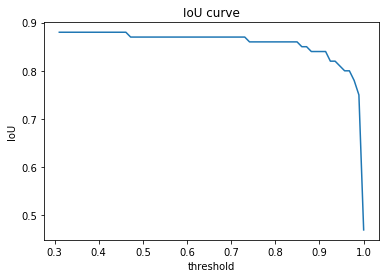

In [195]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

#plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [196]:
wsThresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(wsThresh, max(IoUValList)))

Thresh: 0.31076923076923074  ExpectedIoU: 0.8800000000000001


## Threshold optimization

In [20]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(13)):
    thresh = (1+kk)/13
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([ModelUNet.IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )

100%|██████████| 13/13 [01:21<00:00,  6.27s/it]


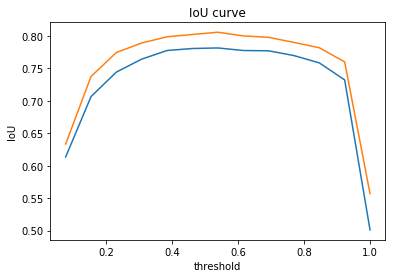

In [21]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [22]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.5384615384615384  ExpectedIoU: 0.8058020477815699


In [23]:
thresh = 0.5

# Joint Optimization of Pixel Count and Threshold

In [24]:
def AdapThresh(pred_logits, threshPixels, thresh, threshL, threshH):
    pred_t = np.zeros_like(pred_logits)
    for i in range(len(pred_logits)):
        pred_t[i] = (pred_logits[i] > thresh).astype(np.uint8)
        if pred_t[i].sum() > threshPixels:
            pred_t[i] = (pred_logits[i] > threshL).astype(np.uint8)
        else:
            pred_t[i] = (pred_logits[i] > threshH).astype(np.uint8)
    return pred_t

def ComputeIoU(pred_logits, G0, threshPixels, thresh, threshL, threshH):
    pred_t = AdapThresh(pred_logits, threshPixels, thresh, threshL, threshH)
    meanIoUVal = np.array([ModelUNet.IoU(pred_t[i].astype(np.uint8), G0[i].astype(np.uint8)) for i in range(G0.shape[0])])
    return np.mean(meanIoUVal)

In [25]:
#threshold pixels, threshold value, threshold low (high pix count), threshold high (low pix count)
parameters = []
nRuns = 3000
bestSoFar = 0
for k in tqdm(range(nRuns)):
    threshPix = np.random.randint(1,101*30)
    threshM = 0.3+0.7*np.random.random()
    threshL = threshM*np.random.random()
    threshH = threshM + (1 - threshM)*np.random.random()
    
    meanIoU = ComputeIoU(preds_val, Y_val, threshPix, threshM, threshL, threshH)
    if meanIoU > bestSoFar:
        bestSoFar = meanIoU
        print('Best mean IoU improved to {}'.format(bestSoFar))
    parameters.append([threshPix, threshM, threshL, threshH, meanIoU])
    
parameters = np.array(parameters)

bestparams = np.array([parameters[q] for q in range(len(parameters)) if parameters[q,4] == bestSoFar])

#print('Best set of parameters: {}'.format(parameters[ np.argmax(parameters,0)[4] ]))
print('Best set of parameters: {}'.format(bestparams[:,0:4]))
print(np.argmax(parameters,0))
#print(parameters)


  0%|          | 1/3000 [00:01<1:12:20,  1.45s/it]

Best mean IoU improved to 0.7856810244470314


  0%|          | 2/3000 [00:02<1:11:59,  1.44s/it]

Best mean IoU improved to 0.8232828870779977


  0%|          | 5/3000 [00:07<1:11:51,  1.44s/it]

Best mean IoU improved to 0.8307334109429568


  0%|          | 6/3000 [00:08<1:11:52,  1.44s/it]

Best mean IoU improved to 0.8318975552968567


  0%|          | 10/3000 [00:14<1:11:52,  1.44s/it]

Best mean IoU improved to 0.8320139697322468


  1%|          | 20/3000 [00:28<1:11:35,  1.44s/it]

Best mean IoU improved to 0.8403958090803261


  2%|▏         | 68/3000 [01:37<1:10:24,  1.44s/it]

KeyboardInterrupt: 

TypeError: list indices must be integers or slices, not tuple

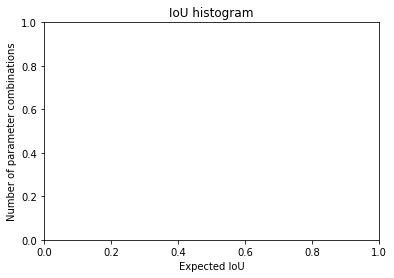

In [26]:
plt.title('IoU histogram')
plt.ylabel('Number of parameter combinations')
plt.xlabel('Expected IoU')

plt.hist(parameters[:,4], bins=50)

In [178]:
threshPixels=2.73000000e+02 
threshM= 4.09481043e-01 
threshL= 1.72299956e-01 
threshH= 8.70076138e-01

# Predictions

In [24]:
#X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
#X_test = X_test/255.0 #(X_test-X_train_mean)/(2*X_train_std)

#for i in tqdm(range(len(X_test))):
#    X_test[i] = image_datagen.standardize(X_test[i].astype(float))

  0%|          | 39/18000 [00:00<00:46, 386.11it/s]

Getting images and masks ... 


100%|██████████| 18000/18000 [00:46<00:00, 387.38it/s]


Ignored 92 files


In [26]:
cObjs = {'ModelUNet' : ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }
model_array = [
               load_model('model-tgs-salt-1f-0.h5', custom_objects=cObjs), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               load_model('model-tgs-salt-1e-0.h5', custom_objects=cObjs), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               load_model('model-tgs-salt-1e-1.h5', custom_objects=cObjs), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               load_model('model-tgs-salt-1c.h5', custom_objects=cObjs), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               load_model('model-tgs-salt-1d.h5', custom_objects=cObjs), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               load_model('model-tgs-salt-1a.h5', custom_objects=cObjs) #, 'ReflectionPadding2D' : ReflectionPadding2D})
               #load_model('model-tgs-salt-XcepDiv255_785.h5', custom_objects={'ModelUNet' : ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               #load_model('model-tgs-salt-IVDLabDiv255_795.h5', custom_objects={'ModelUNet' : ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               #load_model('model-tgs-salt-DeeplabDiv255rmsprop785.h5', custom_objects={'ModelUNet' : ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }), #, 'ReflectionPadding2D' : ReflectionPadding2D})
               #load_model('model-tgs-salt-DeeplabDiv255_805.h5', custom_objects={'ModelUNet' : ModelUNet, 'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss, '_expand': ModelUNet._expand, 'relu6': DeepLabv3Plus.relu6, 'BilinearUpsampling': DeepLabv3Plus.BilinearUpsampling }) #, 'ReflectionPadding2D' : ReflectionPadding2D})
               #load_model('model-tgs-salt-Resnet.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-ReflecConv.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-Incep1.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
              ]

# Predict on train, val and test

preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)
preds_test = model.predict([X_test, d_test], verbose=1)

for savedModel in model_array:
    preds_train += savedModel.predict([X_train0, d_train0], verbose=1)
    preds_val += savedModel.predict([X_val, d_val], verbose=1)
    preds_test += savedModel.predict([X_test, d_test], verbose=1)

preds_train /= 1+len(model_array)
preds_val /= 1+len(model_array)
preds_test /= 1+len(model_array)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 247s 14ms/step


In [180]:
#Watershed predictions
#preds_test_t = ModelUNet.WaterShedChangeAll(preds_test, lowThresh = 0.1, highThresh = wsThresh)

In [181]:
#quadruple-threshold preds
preds_test_t = AdapThresh(preds_test, threshPixels, threshM, threshL, threshH)

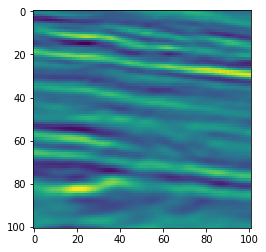

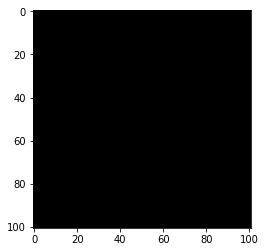

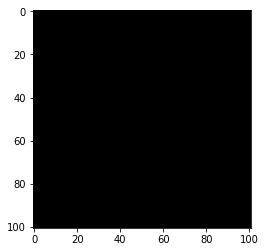

In [182]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train0[ix,:,:,0])
plt.show()
#plt.imshow(Y_train[ix,:,:,0])
tmp = np.squeeze(Y_train0[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [27]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 5 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

56

In [184]:
testEmptyIDs = [imgId for imgId in range(len(preds_test)) if preds_test[imgId].max() < 0.1]
nonSaltTestImgs = X_test[testEmptyIDs]
nonSaltTestDpth = d_test[testEmptyIDs]
len(testEmptyIDs)

6239

In [28]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [29]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [30]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

18000it [04:46, 62.89it/s]


In [31]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [32]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [33]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "DeepLabv3, initial_lr=.0005, thresh, backbone=xception, randomcrops"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('submission.zip')